<h2>Imports</h2>

In [197]:
import requests
import json
from http import HTTPStatus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

API_ENDPOINT = 'https://api.coronavirus.data.gov.uk/v1/data'

<h2>Activity 1</h2>

<h3>1.1 Sub-activity: Open Data COVID-19 API</h3>

<h4>Task 1</h4>

In [198]:
# Code follows the structure of the API documentation, general structure is is taken from the API documentation example:
# https://coronavirus.data.gov.uk/details/developers-guide/main-api
def get_API_data(filters, structure):
    """
    Takes in a dictionary of filters and a dictionary of the structure of the data we woould like to retreive 
    and returns the data from the API. Will return all pages of data if there are multiple pages.

    Args:
        filters (dict): dictionary of filters to be applied to the data (e.g. areaType, areaName)
        structure (dict): dictionary of the structure of the data we would like to retreive (e.g. date, areaName, newCasesByPublishDate)
        See API documentation for more information on filters and structure: https://coronavirus.data.gov.uk/metrics
    Raises:
        RuntimeError: Returns an HTTPS error code from requests library the if the request fails

    Returns:
        list: list of json dictionaries of the data retreived from the API
    """
    
    params = {
    "filters": str.join(";", filters['filters']),
    "structure": json.dumps(structure, separators=(",", ":"))
    }
    data = []
    page_number = 1
    while True:
    # Adding page number to query params
        params["page"] = page_number

        response = requests.get(API_ENDPOINT, params = params)
        response_json = response.json()
        data.extend(response_json['data'])
        # if request_counter % 10 == 0:
        #     time.sleep(100)
        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
        
        if response_json["pagination"]["next"] is None:
            break

        page_number += 1
    
    return data

<h4>Task 2</h4>

In [199]:
# Dictionary of area types and their corresponding API values
AREA_TYPE = {"nat": "nation", "rgn": "region"}

# Dictionary of the structure of the data we would like to retreive from the API
REQUEST_STRUCTURE = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}

# Dictionary of the structure of the data we would like to retreive from the API
def get_filters(area_type): 
    """
    Function that takes in an area type and returns a dictionary of filters to be applied to the data.

    Args:
        area_type (str): Area type to be used in the filter (e.g. nation, region)

    Returns:
        dict: dictionary of filters to be applied to the data
    """
    filters = {'filters' : [
        f"areaType={ area_type }",
    ]}
    return filters



In [200]:
# Create national and regional filters
national_filter = get_filters(AREA_TYPE["nat"])
regional_filter = get_filters(AREA_TYPE["rgn"])
# Get data from API for national and regional data
results_json_national = get_API_data(national_filter, REQUEST_STRUCTURE)
results_json_regional = get_API_data(regional_filter, REQUEST_STRUCTURE)

<h3>1.2 Sub-activity: Shaping the COVID data into different dataframes</h3>

<h4>Task 3</h4>

In [201]:
# Combine national and regional data into one list
combined_results_json = results_json_national + results_json_regional

<h4>Task 4</h4>

In [202]:
# Add combined data to a pandas dataframe
covid_data = pd.DataFrame(combined_results_json)
covid_data.head()

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
0,2022-12-14,England,3393.0,20350226.0,NaN,NaN,41983471.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
1,2022-12-13,England,5510.0,20346833.0,NaN,NaN,41982966.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
2,2022-12-12,England,5669.0,20341323.0,NaN,NaN,41982478.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
3,2022-12-11,England,3932.0,20335654.0,NaN,NaN,41982091.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4,2022-12-10,England,3071.0,20331722.0,NaN,NaN,41981702.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."


<h4>Task 5</h4>

In [203]:
# Drop England from the dataframe as it is alrady included in the regional data
covid_data.drop(covid_data.loc[covid_data["name"]=="England"].index, inplace=True)


<h4>Task 6</h4>

In [204]:
# Rename the "name" column to "area" for clarity
covid_data.rename({"name": "area"}, axis=1, inplace=True)

<h4>Task 7</h4>

In [205]:
# Convert values in the "date" column to datetime objects
covid_data["date"] = pd.to_datetime(covid_data["date"], format="%Y-%m-%d")

<h4>Task 8</h4>

In [206]:
# Replace empty lists in the "vaccination_age" column with NaN values
covid_data["vaccination_age"] = covid_data["vaccination_age"].apply(lambda value_list: value_list if value_list else np.nan)
# Display summary of DataFrame to check for data and missing data (missing data is represented as NaN values)
covid_data.info()
print("\nMissing data from each columnn: \n{}".format(covid_data.isnull().sum()))
print("\nTotal number of missing values is: {}".format(covid_data.isnull().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12230 entries, 1050 to 13279
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12230 non-null  datetime64[ns]
 1   area                   12230 non-null  object        
 2   daily_cases            12218 non-null  float64       
 3   cumulative_cases       12218 non-null  float64       
 4   daily_deaths           10241 non-null  float64       
 5   cumulative_deaths      10255 non-null  float64       
 6   cumulative_vaccinated  7368 non-null   float64       
 7   vaccination_age        7277 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 764.5+ KB

Missing data from each columnn: 
date                        0
area                        0
daily_cases                12
cumulative_cases           12
daily_deaths             1989
cumulative_deaths        1975
cumulative_v

<h4>Task 9</h4>

In [207]:
# Backfill missing data in the "cumulative_cases", "cumulative_deaths" and "cumulative_vaccinated" columns
# I.e fill in missing values with the last known value
covid_data[["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"]] = covid_data.groupby(["area"])[["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"]].bfill()


<h4>Task 10</h4>

In [208]:
# Drop rows with missing data in the "cumulative_cases", "cumulative_deaths" and "cumulative_vaccinated" columns
covid_data.dropna(subset = ["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"], inplace=True)
# Drop duplicate rows in the dataframe that have the same area and dat. Keep the last row as this will be the most up to date data
covid_data.drop_duplicates(subset=["area", "date"], keep ="last", inplace=True)
# Reset the index of the dataframe
covid_data.reset_index(drop=True, inplace=True)

<h4>Task 11</h4>

In [209]:
# Compute and add new columns to the dataframe for the daily rolliing avg cases and deaths.
covid_data[["daily_cases_roll_avg", "daily_deaths_roll_avg"]] = covid_data.sort_values("date").groupby(["area"])[["daily_cases", "daily_deaths"]].rolling(7).mean().reset_index(level=0, drop=True)

<h4>Task 12</h4>

In [210]:
# Drop the "daily_cases" and "daily_deaths" columns as they are no longer needed
covid_data.drop(labels = ["daily_cases", "daily_deaths"], axis = "columns", inplace=True)

<h4>Task 13</h4>

In [211]:
# Create a new dataframe with only the data we need for the vaccinations (e.g date, area, cumulative vaccinated and vaccination age)
covid_data_vaccinations = covid_data.loc[:, ["date", "area", "cumulative_vaccinated", "vaccination_age"]]
# Drop vaccination age column from the  covid_data dataframe as it is no longer needed
covid_data.drop("vaccination_age", axis = "columns", inplace=True)

<h4>Task 14</h4>

In [212]:
# Drop rows with missing data in the "vaccination_age" column
covid_data_vaccinations.dropna(axis=0, inplace=True)

In [213]:
# Explode the "vaccination_age" column so that each row represeents available vaccination metrics
#for a specific date, in a specific area, and for a specific age interva
vaccination_age_subset = covid_data_vaccinations.explode(column= "vaccination_age", ignore_index=True)
vaccinations_age_data = pd.json_normalize(vaccination_age_subset["vaccination_age"])
covid_data_vaccinations_wide = pd.concat([vaccination_age_subset, vaccinations_age_data], axis=1)

In [214]:
# Drop columns that are not needed from the dataframe
covid_data_vaccinations_wide.drop(columns = [
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace = True)

<h3>1.3 Sub-activity: Aggregating, plotting, and analysing</h3>

<h4>Task 15</h4>

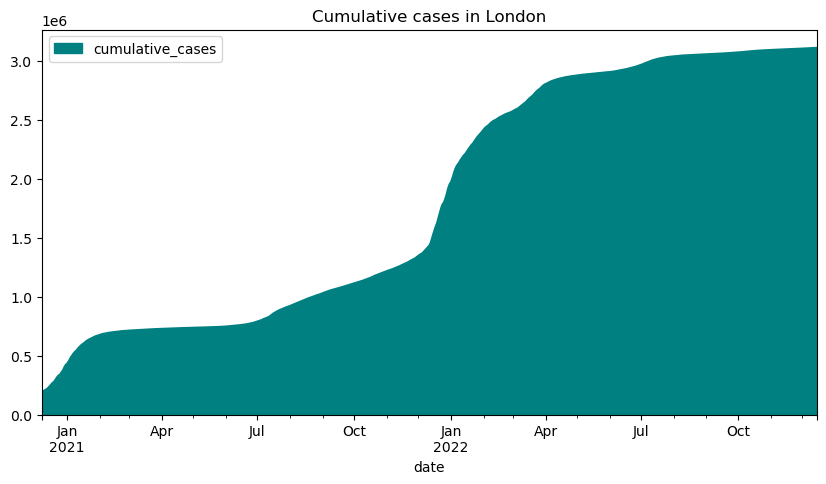

In [215]:
# Get intermediate DataFrame of the cumulative cases by date in London
cumulative_cases_in_london_df = covid_data.loc[covid_data["area"]=="London", ["cumulative_cases", "date"]]

# Plot the cumulative cases in London
cumulative_cases_in_london_df.plot(x="date", y="cumulative_cases", kind="area", color="teal", figsize=(10, 5),
                                        title="Cumulative cases in London")
plt.show()

<h5>Question: Is there a period in time in which the cases plateaued?</h5>

<p>Overall there are two plateaus. Cases started to first plateau in mid Janurary until late June 2021 before they started to increase again. Then they plateaud again after July 2022 up to the presently available data.<p>

<h4>Task 16<h4>

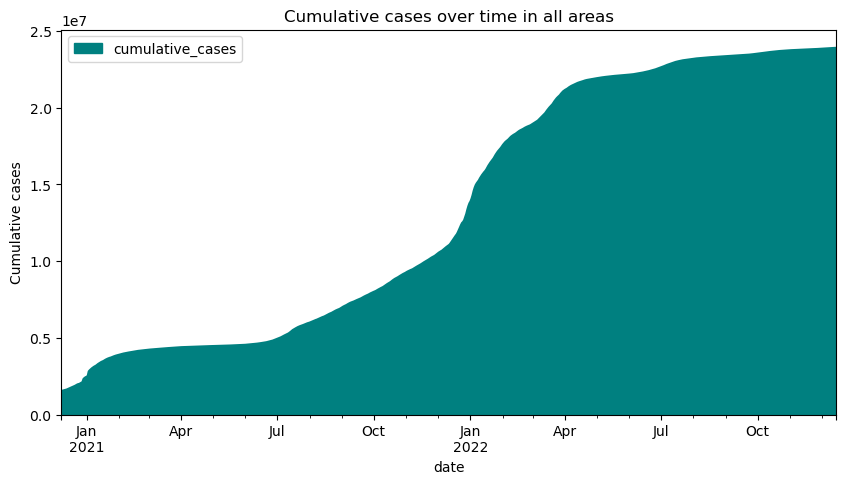

In [230]:
#determine min and max date in the dataset
min_date = covid_data["date"].min()
max_date = covid_data["date"].max()
date_index = pd.date_range(min_date, max_date)

# Get the date ranges for the cumulative cases, deaths and vaccinations by creating an empty dataframe with the date ranges
# for each area and then merging it with the original dataframe
date_range = covid_data.groupby('area').apply(lambda x: x.reindex(date_index))
date_range.drop(labels = ["date", "area"], axis = "columns", inplace=True)
date_range.rename_axis(["area", "date"], inplace=True)
date_range.reset_index(inplace=True)
date_range = date_range.loc[:, ['area', 'date']]
# Merge the date range dataframe with the original dataframe to get the cumulative cases, deaths and vaccinations with filled
# in missing values for each date range. Missing values are backfilled with the last known value. Anything not filled is dropped
merged_cumulative_df = pd.merge(date_range, covid_data, how = "outer", on = ["area", "date"])
merged_cumulative_df[["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"]] = merged_cumulative_df.sort_values(by=["date"], ascending=False).groupby(["area"])[["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"]].bfill()
merged_cumulative_df.dropna(subset = ["cumulative_cases", "cumulative_deaths", "cumulative_vaccinated"], inplace=True)

# Resample the merged dataframe to get the cumulative cases over time for all areas
cumulative_cases_over_time_df = merged_cumulative_df.resample("D", on="date").sum()
# Plot the cumulative cases over time in all areas using the merged dataframe
cumulative_cases_over_time_df.plot(y="cumulative_cases", kind="area", color="teal", figsize=(10, 5), title="Cumulative cases over time in all areas")
plt.ylabel("Cumulative cases")
plt.show()

<h5>How does the pattern seen in London hold country-wide?</h5>

<p>Overall London follows the same pattern that is seen country wide. With plateaus at the same two periods (mid Janurary until late June 2021 and July 2022 up to the presently available data).<p>

<h4>Task 17<h4>

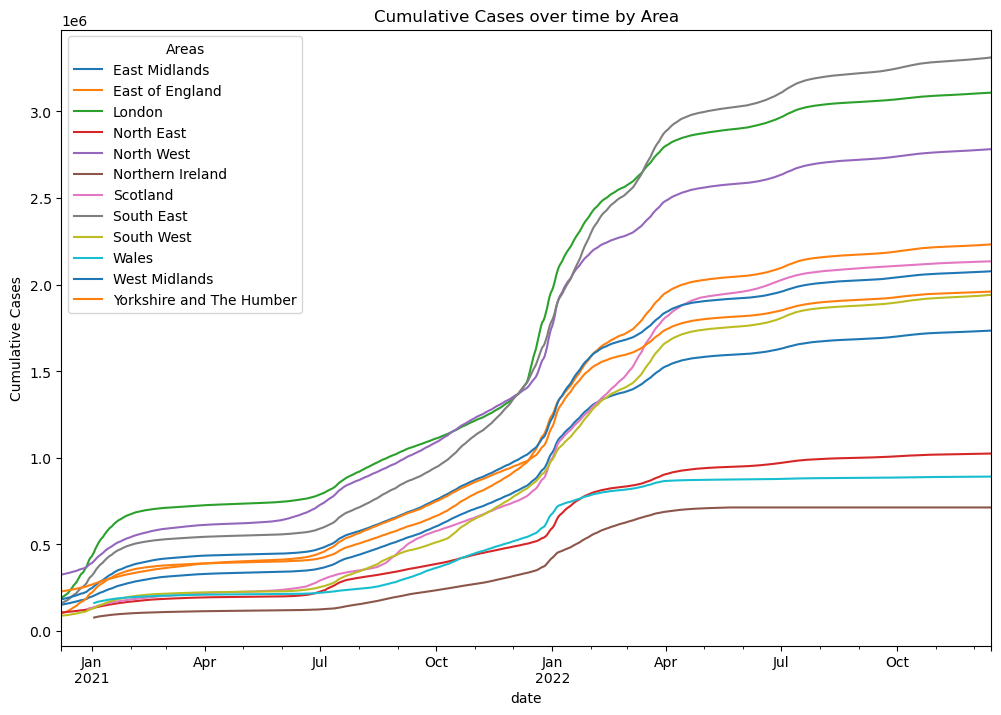

In [217]:
# Get intermmediatee dataframe of the cumulative cases grouped by area
cumulative_cases_all_regions = merged_cumulative_df.set_index("date").groupby("area")
plt.figure(figsize=(12, 8))
# Create a line plot for each area
cumulative_cases_all_regions['cumulative_cases'].plot(legend=True, title="Cumulative Cases over time by Area")
plt.ylabel("Cumulative Cases")
plt.legend(title="Areas")
# Show the plot
plt.show()

<h5>Question: What patterns do all nations/regions share?</h5>

<p>All nations plateaud in thee same periods previously mention. Furthermore all areas experienced a gradual increase in cases from July 2021 until January 2022. After this the cases rapid spiked for all of them before levelling off around April 2022<p>

<h4>Task 18<h4>

<h5>Question: As a data scientist you will often need to interpret data insights, based on your
own judgement and expertise. Considering the data and plot from the last question, what
event could have taken place in June-July that could justify the trend seen from there
onward?</h5>

<p>June-July (2021): Saw an increase cases again likely as a result of loosening lockdown restrictions. Which allowed people to socially mix again, with restrictions fully lifted in mid to llate July, when cases increase faster.<p>
<p>June-July (2022): Saw gradual increases in cases from April onwards, as a result of the lifting of all restrictions and reduced testing. Some regions such and Northern Ireland stopped repoorting cases numbers all together (https://coronavirus.data.gov.uk/about).
June and July saw faster increases possibly due to the lack of the restrictions and emergence of a new Omicron sub variant (BA4 and BA5)</p>

<h4>Task 19<h4>

<class 'pandas.core.frame.DataFrame'>


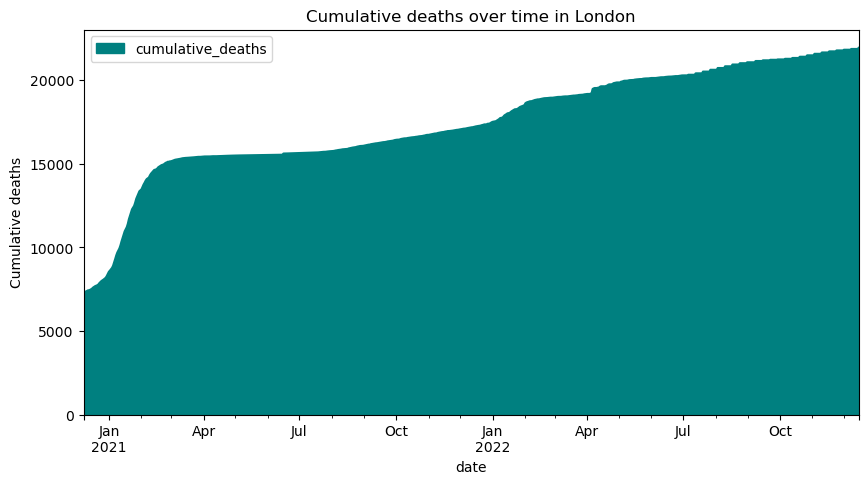

In [231]:
# Get intermediate dataframe of the cumulative deaths grouped by area and sampled on Date to get a time series.
cumulative_deaths_all_regions = merged_cumulative_df.loc[merged_cumulative_df["area"]=="London"].resample("D", on="date").sum()
# Plot the cumulative deaths over time in London
cumulative_deaths_all_regions.plot(y="cumulative_deaths", kind="area", color="teal", figsize=(10, 5), title="Cumulative deaths over time in London")
plt.ylabel("Cumulative deaths")
plt.show()

<h5>Question: Is there a noticeable period in time when the ongoing trend is broken? When?</h5>

<p>After February 2021 there deaths never rapidly increased again, compared to before, and mostly stayed gradual. Plateauing for most of 2021 until gradually increasing in the Winter months with a slightly faster increase afteer January 2022. The plateaus is likely a result of the vaccine roll out. While spikes and increases are likely due to immunee evasive subvariants such as Omicron sub variants</p>

<h4>Task 20<h4>

<h5>Question: Based on the data and plot from the last question, is there any similarity between trends in cumulative cases and cumulative deaths?</h5>

<p>Increases in cases usually lead to an increase in deaths, the spikes in deaths occur after a slight time delay from conraction of the virus (lag between contracting and sadly succumbing to it). However the spike after February 2021 are never as sharp annd before, likely due to the vaccine rollout despite the greater number of infections</p>

<h4>Task 21<h4>

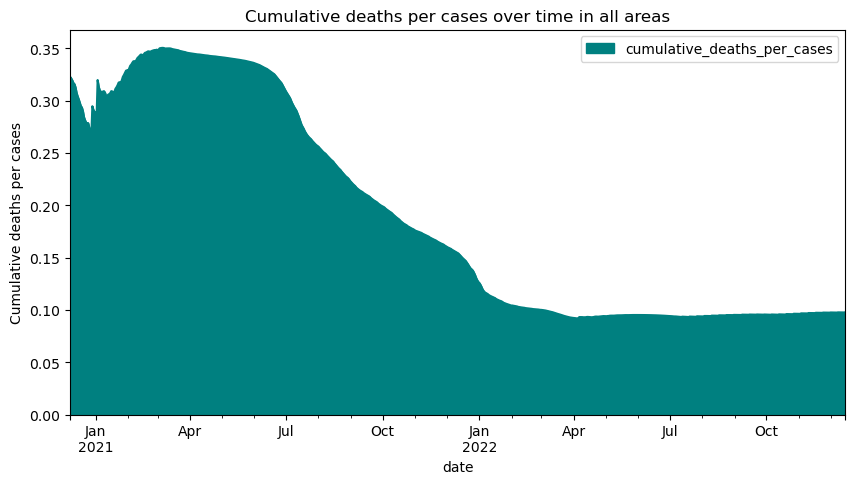

In [219]:
# Copy the merged dataframe to thee covid_data frame to add missing date ranges for each area
covid_data = merged_cumulative_df
# Add a new column to the dataframe to calculate the cumulative deaths per cases
covid_data["cumulative_deaths_per_cases"] = covid_data["cumulative_deaths"]/covid_data["cumulative_cases"]
# Create intermediate dataframe of the cumulative deaths per cases grouped by area and sampled on Date to get a time series.
cumulative_deaths_per_cases_all_regions = covid_data.resample("D", on="date").sum()
# Plot the cumulative deaths per cases over time in all areas
cumulative_deaths_per_cases_all_regions..plot(y="cumulative_deaths_per_cases", 
                kind="area", color="teal", figsize=(10, 5), title="Cumulative deaths per cases over time in all areas")
plt.ylabel("Cumulative deaths per cases")
plt.show()

<h5>What overall trends can be seen?</h5>

<p>In early 2021 the deathds per case was significantly higher and started to decrease vrey rapidly after April (from a peak of about 35% down to 10% in April 2022. After which it has largely reemained constant</p>

<h4>Task 22<h4>

<h5>Question: Based on the data and plot from the last question, it seems like, in June-July,
the graph’s inclination gets steeper. What could be a reasonable explanation?</h5>

<p>June-July 2021: The faster drop is likely due to increased vaccine availability to all age groups. Which resulted in fewer deaths and a greater decreas ein the deaths per cases.<p>

<h4>Task 23<h4>

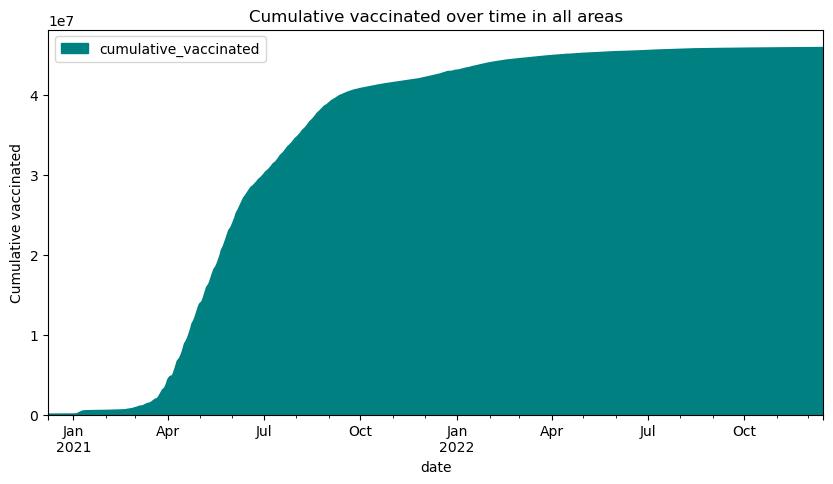

In [220]:
# Get intermediate dataframe of the cumulative vaccinations grouped by area and sampled on Date to get a time series.
cumulative_vaccinations_all_regions = covid_data.resample("D", on="date").sum()
# Plot the cumulative vaccinations over time in all areas
cumulative_vaccinations_all_regions.plot(y="cumulative_vaccinated", 
                kind="area", color="teal", figsize=(10, 5), title="Cumulative vaccinated over time in all areas")
plt.ylabel("Cumulative vaccinated")
plt.show()

<h5>Question: Are there any relationships between the trends seen here and the ones seen
in Task 21?</h5>

<p>They are inversely related. After the increase in vaccinations in April, the deaths per cases started to come down too.<p>

<h4>Task 24<h4>

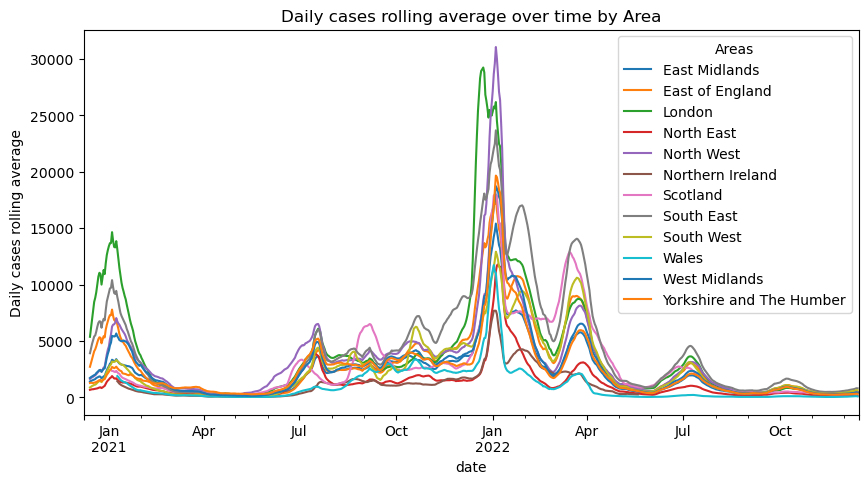

In [234]:
# Get intermediate dataframe of the daily rolling avg cases grouped by area.
daily_rolling_avg_df = covid_data.set_index("date").groupby(["area"])['daily_cases_roll_avg']

plt.figure(figsize=(10, 5))
# Create a line plot for each area to show the daily rolling average cases over time
daily_rolling_avg_df.plot(legend=True, title="Daily cases rolling average over time by Area")
plt.ylabel("Daily cases rolling average")
plt.legend(title="Areas")
plt.show()

<h5>Question: Is there a specific area that seems to escape the general trend in any way?
Which one and how?</h5>

<p>Northern Irelad doesn't seem to have the same spikes seen everywhere else outside of the January 2022 spikes.<p>

<h4>Task 25<h4>

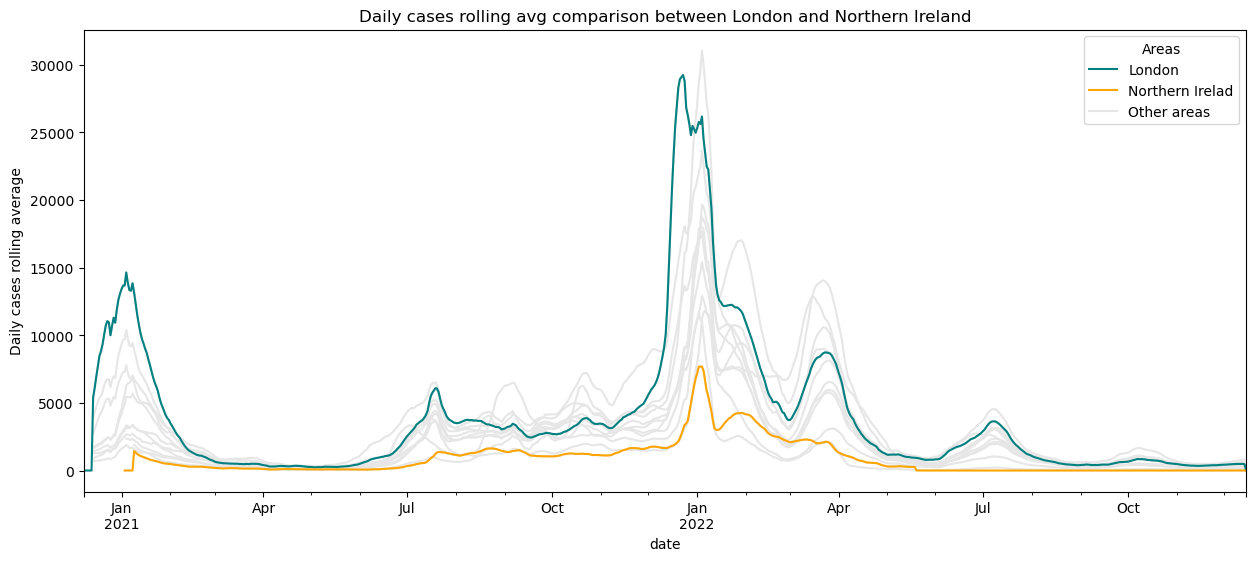

In [222]:
# Get the daily rolling average cases for London and Northern Ireland and save in their own dataframes
daily_cases_rolling_average_London = covid_data[covid_data["area"] == "London"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_Northern_Ireland = covid_data[covid_data["area"] == "Northern Ireland"].groupby(["date"])["daily_cases_roll_avg"].sum()

# Plot the daily rolling average cases for London and Northern Ireland against the other areas to compare changes oveer time
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
daily_rolling_avg_df['daily_cases_roll_avg'].plot(ax=ax, color = "#e6e6e6", title="Daily cases rolling avg comparison between London and Northern Ireland")
daily_cases_rolling_average_London.plot(ax=ax, color = "teal")
daily_cases_rolling_average_Northern_Ireland.plot(ax=ax, color = "orange")
plt.ylabel("Daily cases rolling average")
plt.legend(["London", "Northern Ireland", "Other areas"], title = "Areas")
ax.get_legend().legendHandles[0].set_color("teal")
ax.get_legend().legendHandles[1].set_color("orange")
ax.get_legend().legendHandles[2].set_color("#e6e6e6")
plt.show()

<h5>Question: What reasons there might be to justify this difference?</h5>

<p>Northern Ireland doesn't seem to have the same spikes seen everywhere else outside of the January 2022 spikes. Several reasons could explain this trend. For one the population is way lower than other regions soo the data looks a little skeweed if not adjusted for population. Furthermore lockdown restrictions that lasteed for most of 2021 may have suppressed the spread more than other areas, wiith a spike seen in January 2022 wheen reestrictions were lifted. Beyond May 2022 reporting stopped entirely, thus no patterns can be inferred.<p>

<h4>Task 26<h4>

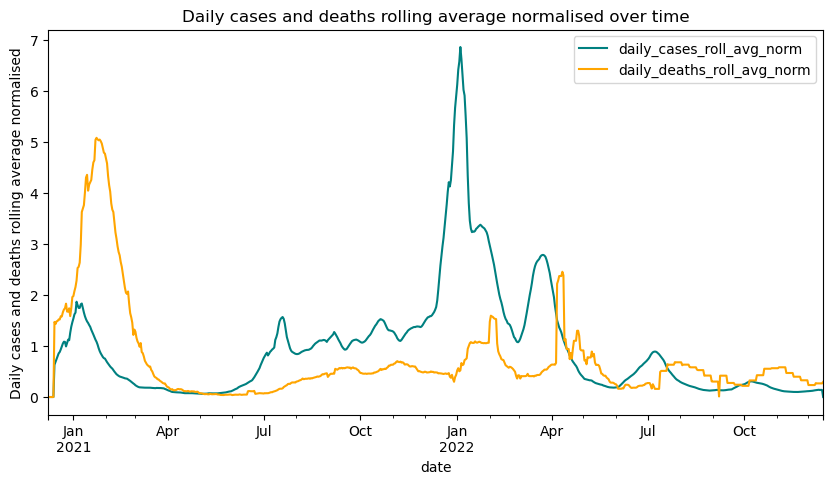

In [223]:
# Normalise the daily rolling average cases and deaths over time and save to new columns daily_cases_roll_avg_norm and daily_deaths_roll_avg_norm
covid_data[["daily_cases_roll_avg_norm", "daily_deaths_roll_avg_norm"]] = covid_data[["daily_cases_roll_avg", "daily_deaths_roll_avg"]].div(covid_data[["daily_cases_roll_avg", "daily_deaths_roll_avg"]].max())
#get the normalised data grouped by date and sum the normalised values as a dataframe
normalised_data_df = covid_data.groupby("date")[["daily_cases_roll_avg_norm", "daily_deaths_roll_avg_norm"]].sum()
# Plot the normalised daily rolling average cases and deaths over time to compare changes over time
normalised_data_df.plot(color=["teal", "orange"], figsize=(10, 5), title="Daily cases and deaths rolling average normalised over time")
plt.ylabel("Daily cases and deaths rolling average normalised")
plt.show()

<h5>Question: Are daily trends of cases and deaths increasing and decreasing at the same rates? What part of the plot tells you this?</h5>

<p>The geneeral trend seems to imply that there is a time delay between daily cases and deaths. Which makes sense given the time elapsed from conotracting th virus and detoriation of symptoms. After Aapril 2021 the increase in deaths corresponding the the increase in cases after accounting for the time delay is less. This is especially clear in July 2021, January 2022 and a less extent March 2022, where massive daily spikes, show smaller spikes in deaths.<p>
<p>After 2022 the increased rate, could likely be a result of immune evasive variants ssuch as Omicron</p>

<h4>Task 27<h4>

In [224]:
# Split data frame to get data for London and retrieve only the date, age and cumulative vaccination first dose uptake by vaccination date percentage columns
# Pivot the dataframe so that each row corresponds to a date, each column corresponds to an age interval, and the data in a dataframe cell is the value of
# cumVaccinationFirstDoseUptakeByVaccinat
london_covid_vaccination_wide = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
london_covid_vaccination_wide = london_covid_vaccination_wide[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
london_covid_vaccination_df = london_covid_vaccination_wide.pivot(index = "date", columns = "age", values = "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage")

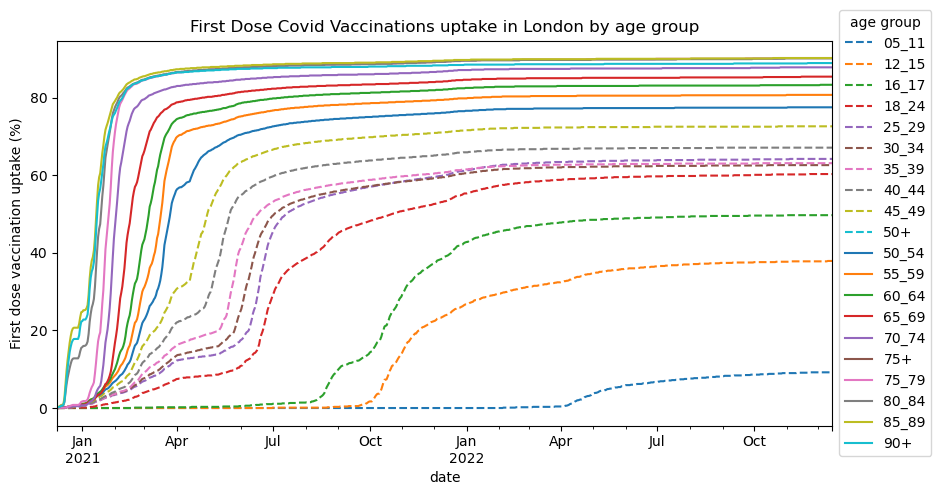

In [225]:
# Plot the first dose vaccination uptake in London by age group
london_covid_vaccination_df.plot(figsize=(10, 5), title="First Dose Covid Vaccinations uptake in London by age group", style=["--" for _ in range(10)])
plt.legend(title = "age group", loc = "center left", bbox_to_anchor = (1, 0.5))
plt.ylabel("First dose vaccination uptake (%)")
plt.show()
# london_covid_vaccination_df.head()

<h5>Question: Were all age groups vaccinated equally and at the same time, or was there a strategy employed? What strategy does the plot indicate and why?</h5>

<p>Older age groups particularly those that were 80+ were vaccinated first iin late 2020, followed by other age group in decreasing order of age in increments of 5 yeears frmo January 2021 up until June-July 2021 for the 18+ age group. Due to regulatory approvals age groups younger than this weren't vaccinated until much later. The general strategy was to vaccinate the elderly and those with pre-existing health conditions that could be more susceptable to severe disease, regardless of age groups first. This is shown by the early spikes in the elderly ages groups and small gradual increases for all the age groups up to the 18+ from January 2021 onwards.<p>

<h4>Task 28<h4>

In [226]:
# Split data frame to get data for Scotland and retrieve only the date, age and cumulative vaccination first dose uptake by vaccination date percentage columns
# Pivot the dataframe so that each row corresponds to a date, each column corresponds to an age interval, and the data in a dataframe cell is the value of
# cumVaccinationFirstDoseUptakeByVaccinat
scotland_covid_vaccination_wide = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]
scotland_covid_vaccination_wide = scotland_covid_vaccination_wide[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
scotland_covid_vaccination_df = scotland_covid_vaccination_wide.pivot(index = "date", columns = "age", values = "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage")

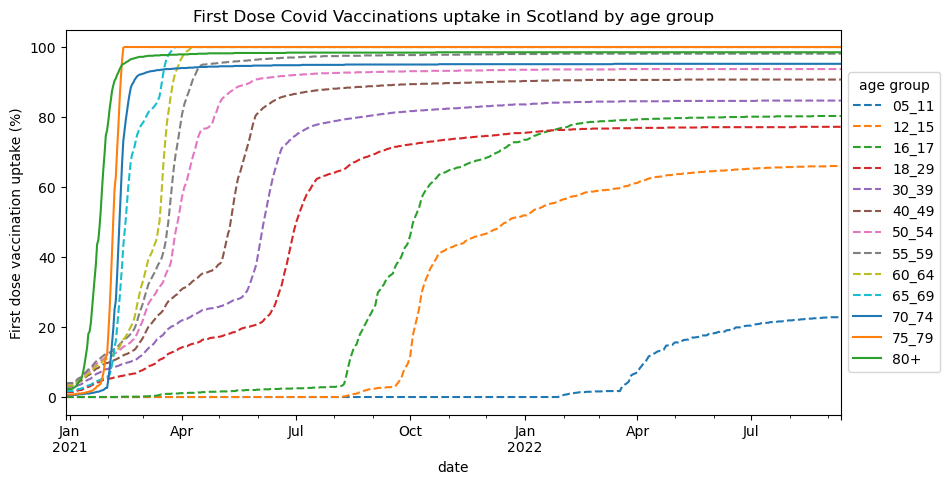

In [227]:
# Plot the first dose vaccination uptake in Scotland by age group
scotland_covid_vaccination_df.plot(figsize=(10, 5), title="First Dose Covid Vaccinations uptake in Scotland by age group", style=["--" for _ in range(10)])
plt.legend(title = "age group", loc = "center left", bbox_to_anchor = (1, 0.5))
plt.ylabel("First dose vaccination uptake (%)")
plt.show()

<h5>Question: In both plots, compare how vaccination evolved for two sections of population: 50-64 years and 65-79 years. Were there any differences in the strategies employe between London and Scotland for dealing with both sections?</h5>

<p>The main difference was that London vaccinateed the 50-64 years and 65-79 years, in age groups of 5 (i.e 75-79 first, then 70-74 etc.) years in dereasing order at a time. While Scotland vaccinated the 50-64 years and 65-79 as two age groups (i.e 65-79 togetheer first and theen 50-64). However the overall strategies were very similar. Namely vaccinate the elderly group 80+ and those with pre existing health conditions that could be more susceptable to severe disease first, followed by the 70+ group and go down in age groups from there.<p>